In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 72%|███████▏  | 716/1000 [01:00<00:23, 12.32it/s]

Epoch 05721: reducing learning rate of group 0 to 5.0000e-02.


100%|██████████| 1000/1000 [01:23<00:00, 11.93it/s]


tensor([13.8734, 23.2425, 31.0689,  ..., 17.3759, 20.3211, 23.2475])

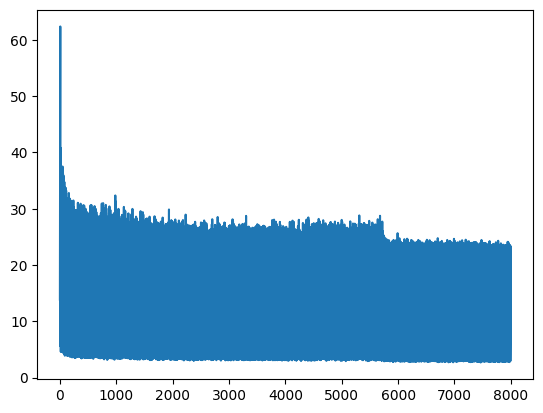

In [16]:
from perf_gen import BNAFPerfGenExperiment
from models.bnaf import BNAFlow
from datasets import sample_2d_data

import wandb
import torch

wandb.init(mode="disabled")

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = BNAFlow()
gaussians = sample_2d_data("8gaussians", 1000)
model.train(gaussians, 1000)


# obj = BNAFPerfGenExperiment("8_gaussians", gaussians, 0.1)

In [ ]:
import torch
import math


class Sequential(torch.nn.Sequential):
    """
    Class that extends ``torch.nn.Sequential`` for computing the output of
    the function alongside with the log-det-Jacobian of such transformation.
    """

    def forward(self, inputs: torch.Tensor):
        """
        Parameters
        ----------
        inputs : ``torch.Tensor``, required.
            The input tensor.
        Returns
        -------
        The output tensor and the log-det-Jacobian of this transformation.
        """

        log_det_jacobian = 0.0
        for i, module in enumerate(self._modules.values()):
            inputs, log_det_jacobian_ = module(inputs)
            log_det_jacobian = log_det_jacobian + log_det_jacobian_
        return inputs, log_det_jacobian


class BNAF(torch.nn.Sequential):
    """
    Class that extends ``torch.nn.Sequential`` for constructing a Block Neural
    Normalizing Flow.
    """

    def __init__(self, *args, res: str = None):
        """
        Parameters
        ----------
        *args : ``Iterable[torch.nn.Module]``, required.
            The modules to use.
        res : ``str``, optional (default = None).
            Which kind of residual connection to use. ``res = None`` is no residual
            connection, ``res = 'normal'`` is ``x + f(x)`` and ``res = 'gated'`` is
            ``a * x + (1 - a) * f(x)`` where ``a`` is a learnable parameter.
        """

        super(BNAF, self).__init__(*args)

        self.res = res

        if res == "gated":
            self.gate = torch.nn.Parameter(torch.nn.init.normal_(torch.Tensor(1)))

    def forward(self, inputs: torch.Tensor):
        """
        Parameters
        ----------
        inputs : ``torch.Tensor``, required.
            The input tensor.
        Returns
        -------
        The output tensor and the log-det-Jacobian of this transformation.
        """

        outputs = inputs
        grad = None

        for module in self._modules.values():
            outputs, grad = module(outputs, grad)

            grad = grad if len(grad.shape) == 4 else grad.view(grad.shape + [1, 1])

        assert inputs.shape[-1] == outputs.shape[-1]

        if self.res == "normal":
            return inputs + outputs, torch.nn.functional.softplus(grad.squeeze()).sum(
                -1
            )
        elif self.res == "gated":
            return self.gate.sigmoid() * outputs + (1 - self.gate.sigmoid()) * inputs, (
                torch.nn.functional.softplus(grad.squeeze() + self.gate)
                - torch.nn.functional.softplus(self.gate)
            ).sum(-1)
        else:
            return outputs, grad.squeeze().sum(-1)

    def _get_name(self):
        return "BNAF(res={})".format(self.res)


class Permutation(torch.nn.Module):
    """
    Module that outputs a permutation of its input.
    """

    def __init__(self, in_features: int, p: list = None):
        """
        Parameters
        ----------
        in_features : ``int``, required.
            The number of input features.
        p : ``list`` or ``str``, optional (default = None)
            The list of indeces that indicate the permutation. When ``p`` is not a
            list, if ``p = 'flip'``the tensor is reversed, if ``p = None`` a random
            permutation is applied.
        """

        super(Permutation, self).__init__()

        self.in_features = in_features

        if p is None:
            self.p = np.random.permutation(in_features)
        elif p == "flip":
            self.p = list(reversed(range(in_features)))
        else:
            self.p = p

    def forward(self, inputs: torch.Tensor):
        """
        Parameters
        ----------
        inputs : ``torch.Tensor``, required.
            The input tensor.
        Returns
        -------
        The permuted tensor and the log-det-Jacobian of this permutation.
        """

        return inputs[:, self.p], 0

    def __repr__(self):
        return "Permutation(in_features={}, p={})".format(self.in_features, self.p)


class MaskedWeight(torch.nn.Module):
    """
    Module that implements a linear layer with block matrices with positive diagonal blocks.
    Moreover, it uses Weight Normalization (https://arxiv.org/abs/1602.07868) for stability.
    """

    def __init__(
        self, in_features: int, out_features: int, dim: int, bias: bool = True
    ):
        """
        Parameters
        ----------
        in_features : ``int``, required.
            The number of input features per each dimension ``dim``.
        out_features : ``int``, required.
            The number of output features per each dimension ``dim``.
        dim : ``int``, required.
            The number of dimensions of the input of the flow.
        bias : ``bool``, optional (default = True).
            Whether to add a parametrizable bias.
        """

        super(MaskedWeight, self).__init__()
        self.in_features, self.out_features, self.dim = in_features, out_features, dim

        weight = torch.zeros(out_features, in_features)
        for i in range(dim):
            weight[
                i * out_features // dim : (i + 1) * out_features // dim,
                0 : (i + 1) * in_features // dim,
            ] = torch.nn.init.xavier_uniform_(
                torch.Tensor(out_features // dim, (i + 1) * in_features // dim)
            )

        self._weight = torch.nn.Parameter(weight)
        self._diag_weight = torch.nn.Parameter(
            torch.nn.init.uniform_(torch.Tensor(out_features, 1)).log()
        )

        self.bias = (
            torch.nn.Parameter(
                torch.nn.init.uniform_(
                    torch.Tensor(out_features),
                    -1 / math.sqrt(out_features),
                    1 / math.sqrt(out_features),
                )
            )
            if bias
            else 0
        )

        mask_d = torch.zeros_like(weight)
        for i in range(dim):
            mask_d[
                i * (out_features // dim) : (i + 1) * (out_features // dim),
                i * (in_features // dim) : (i + 1) * (in_features // dim),
            ] = 1

        self.register_buffer("mask_d", mask_d)

        mask_o = torch.ones_like(weight)
        for i in range(dim):
            mask_o[
                i * (out_features // dim) : (i + 1) * (out_features // dim),
                i * (in_features // dim) :,
            ] = 0

        self.register_buffer("mask_o", mask_o)

    def get_weights(self):
        """
        Computes the weight matrix using masks and weight normalization.
        It also compute the log diagonal blocks of it.
        """

        w = torch.exp(self._weight) * self.mask_d + self._weight * self.mask_o

        w_squared_norm = (w ** 2).sum(-1, keepdim=True)

        w = self._diag_weight.exp() * w / w_squared_norm.sqrt()

        wpl = self._diag_weight + self._weight - 0.5 * torch.log(w_squared_norm)

        return w.t(), wpl.t()[self.mask_d.bool().t()].view(
            self.dim, self.in_features // self.dim, self.out_features // self.dim
        )

    def forward(self, inputs, grad: torch.Tensor = None):
        """
        Parameters
        ----------
        inputs : ``torch.Tensor``, required.
            The input tensor.
        grad : ``torch.Tensor``, optional (default = None).
            The log diagonal block of the partial Jacobian of previous transformations.
        Returns
        -------
        The output tensor and the log diagonal blocks of the partial log-Jacobian of previous
        transformations combined with this transformation.
        """

        w, wpl = self.get_weights()

        g = wpl.transpose(-2, -1).unsqueeze(0).repeat(inputs.shape[0], 1, 1, 1)

        return (
            inputs.matmul(w) + self.bias,
            torch.logsumexp(g.unsqueeze(-2) + grad.transpose(-2, -1).unsqueeze(-3), -1)
            if grad is not None
            else g,
        )

    def __repr__(self):
        return "MaskedWeight(in_features={}, out_features={}, dim={}, bias={})".format(
            self.in_features,
            self.out_features,
            self.dim,
            not isinstance(self.bias, int),
        )


class Tanh(torch.nn.Tanh):
    """
    Class that extends ``torch.nn.Tanh`` additionally computing the log diagonal
    blocks of the Jacobian.
    """

    def forward(self, inputs, grad: torch.Tensor = None):
        """
        Parameters
        ----------
        inputs : ``torch.Tensor``, required.
            The input tensor.
        grad : ``torch.Tensor``, optional (default = None).
            The log diagonal blocks of the partial Jacobian of previous transformations.
        Returns
        -------
        The output tensor and the log diagonal blocks of the partial log-Jacobian of previous
        transformations combined with this transformation.
        """

        g = -2 * (inputs - math.log(2) + torch.nn.functional.softplus(-2 * inputs))
        return (
            torch.tanh(inputs),
            (g.view(grad.shape) + grad) if grad is not None else g,
        )